In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iriscsv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4247%2F6570%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240824%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240824T040559Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6443441346daa010eec1acbab445b08147c1c4a2fafb8d5191f7e3564676e49af81b6b819bd85673f8aaa031d6e42236048a26c4223125c7088a3607a0e73a343b8d5fb4f9420f2c7a16c3aba6aa720b72930d49e2db8082f5526b3784ea0be26396a7127e2669c334fa4af7858fd4276a43f8341daab34f7644248d21819e9d6aa73cda322adf88072a3e4c76c7a042c557fff470f4c0336b4752f0f65ba2d3cbf7d68619790d6e500cec59973cc3cfec955f2fd3596d48778ac900998a9394cc120ae67275178bdd19daed43420149d82c06438beb6f7037f6592763da3ff371922918f11e695ad4c16e4cb81800a40a90ec1efba2dac02cae49805ff2477b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1307 bytes downloaded
Downloaded and uncompressed: iriscsv
Data source import complete.


In [2]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import pandas as pd
import torch
from torch import nn
import numpy as np


In [4]:
df=pd.read_csv("/kaggle/input/iriscsv/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.drop(columns="Id",axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df["Species"].value_counts()

,count
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


In [7]:
X=df.iloc[:,0 : 4]
Y=df.iloc[:,4:]

In [8]:
X

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [9]:
Y

,Species
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [10]:

from sklearn.preprocessing import OneHotEncoder
one_hot=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
Y=one_hot.fit_transform(Y)
print(Y[: 10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [11]:
# Get the unique values from the original "Species" column
unique_species = df['Species'].unique()

# Print the unique species names
for species in unique_species:
    print(species)


Iris-setosa
Iris-versicolor
Iris-virginica


In [12]:
X = torch.tensor(X.values, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
print(X)
print("===============================================")
print(Y)

tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000],
        [5.4000, 3.9000, 1.7000, 0.4000],
        [4.6000, 3.4000, 1.4000, 0.3000],
        [5.0000, 3.4000, 1.5000, 0.2000],
        [4.4000, 2.9000, 1.4000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.4000, 3.7000, 1.5000, 0.2000],
        [4.8000, 3.4000, 1.6000, 0.2000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [4.3000, 3.0000, 1.1000, 0.1000],
        [5.8000, 4.0000, 1.2000, 0.2000],
        [5.7000, 4.4000, 1.5000, 0.4000],
        [5.4000, 3.9000, 1.3000, 0.4000],
        [5.1000, 3.5000, 1.4000, 0.3000],
        [5.7000, 3.8000, 1.7000, 0.3000],
        [5.1000, 3.8000, 1.5000, 0.3000],
        [5.4000, 3.4000, 1.7000, 0.2000],
        [5.1000, 3.7000, 1.5000, 0.4000],
        [4.6000, 3.6000, 1.0000, 0.2000],
        [5.1000, 3.3000, 1.7000, 0

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [14]:
X_train.shape,X_test.shape

(torch.Size([120, 4]), torch.Size([30, 4]))

In [15]:
y_train.shape,y_test.shape

(torch.Size([120, 3]), torch.Size([30, 3]))

In [16]:
class Multiclass_Classification(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden=nn.Linear(4,8)
    self.act=nn.ReLU()
    self.output=nn.Linear(8,3)

  def forward(self,x):
    x=self.act(self.hidden(x))
    x=self.output(x)
    return x

model=Multiclass_Classification().to(device)
model

Multiclass_Classification(
  (hidden): Linear(in_features=4, out_features=8, bias=True)
  (act): ReLU()
  (output): Linear(in_features=8, out_features=3, bias=True)
)

In [17]:

import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [18]:
# def accuracy_fn(y_true,y_pred):
#   correct=torch.eq(y_true,y_pred).sum().item()
#   acc=(correct/len(y_pred))*100
#   return acc

In [19]:
import torch

def accuracy_fn(y_true, y_pred):
    # If y_true is one-hot encoded, convert it to class labels
    if y_true.dim() > 1:
        y_true = torch.argmax(y_true, dim=1)

    # Calculate accuracy
    correct = torch.sum(y_true == y_pred).item()
    total = len(y_true)
    acc = (correct / total) * 100
    return acc


In [20]:


epochs = 200
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    model.train()
    pred = model(X_train)
    final_pred = torch.softmax(pred, dim=1).argmax(dim=1)
    loss = loss_fn(pred, y_train)
    acc = accuracy_fn(y_train, final_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_final = torch.softmax(test_pred, dim=1).argmax(dim=1)
        test_loss_new = loss_fn(test_pred, y_test)
        test_acc = accuracy_fn(y_test, test_final)

    train_loss.append(loss.item())
    test_loss.append(test_loss_new.item())
    train_accuracy.append(acc)
    test_accuracy.append(test_acc)

    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.4f} | Accuracy : {acc:.2f}% | Test Loss : {test_loss_new:.4f} | Test Accuracy : {test_acc:.2f}%")




Epoch : 0 | Loss : 0.9704 | Accuracy : 75.00% | Test Loss : 0.9349 | Test Accuracy : 76.67%
Epoch : 10 | Loss : 0.7053 | Accuracy : 92.50% | Test Loss : 0.6798 | Test Accuracy : 90.00%
Epoch : 20 | Loss : 0.5232 | Accuracy : 95.83% | Test Loss : 0.5091 | Test Accuracy : 100.00%
Epoch : 30 | Loss : 0.4145 | Accuracy : 96.67% | Test Loss : 0.4175 | Test Accuracy : 100.00%
Epoch : 40 | Loss : 0.3270 | Accuracy : 97.50% | Test Loss : 0.3522 | Test Accuracy : 100.00%
Epoch : 50 | Loss : 0.2502 | Accuracy : 97.50% | Test Loss : 0.2940 | Test Accuracy : 100.00%
Epoch : 60 | Loss : 0.1906 | Accuracy : 97.50% | Test Loss : 0.2458 | Test Accuracy : 100.00%
Epoch : 70 | Loss : 0.1487 | Accuracy : 97.50% | Test Loss : 0.2091 | Test Accuracy : 100.00%
Epoch : 80 | Loss : 0.1193 | Accuracy : 97.50% | Test Loss : 0.1824 | Test Accuracy : 100.00%
Epoch : 90 | Loss : 0.0996 | Accuracy : 97.50% | Test Loss : 0.1630 | Test Accuracy : 100.00%
Epoch : 100 | Loss : 0.0862 | Accuracy : 97.50% | Test Loss : 0

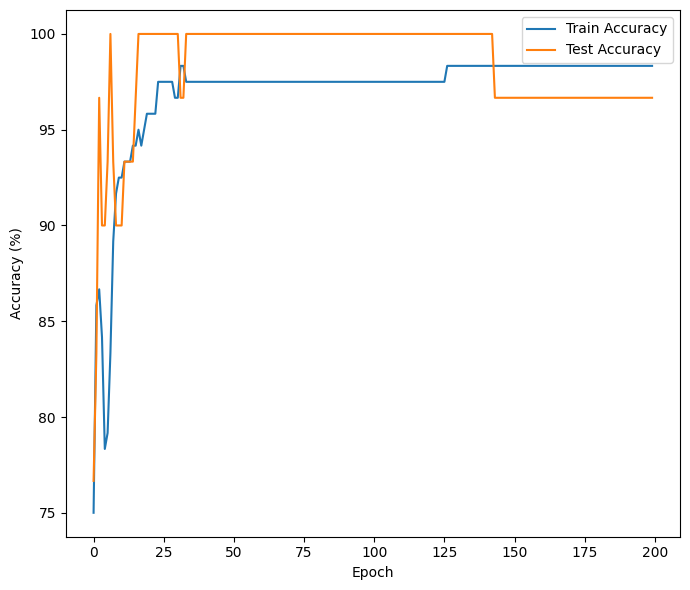

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.plot(range(epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

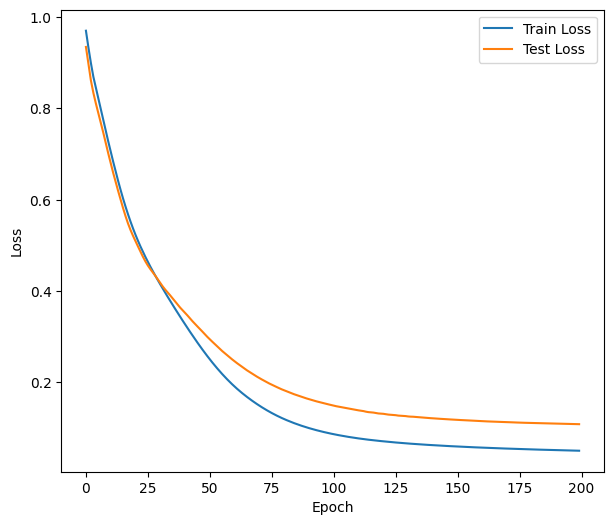

In [22]:
plt.figure(figsize=(7, 6))
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

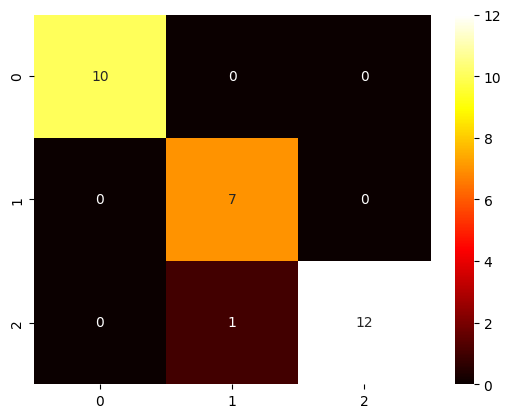

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
y_true= np.argmax(y_test, axis=1)
final_pred = np.array(test_final)
cf= confusion_matrix(y_true, final_pred)
sns.heatmap(cf,annot=True,cmap="hot")
plt.show()

In [24]:
print(classification_report(y_true, final_pred))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.88      1.00      0.93         7
           2       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



# Custom Data Prediction

In [25]:
f1=5.1
f2=3.5
f3=1.4
f4=0.2
x=torch.tensor([[f1,f2,f3,f4]])
x=x.to(device)
model.eval()
with torch.inference_mode():
  prediction=model(x)
class_probability=torch.softmax(prediction,dim=1)
label=class_probability.argmax(dim=1)
final_label=label.cpu().detach().numpy()
print(f"Predicted Label is : {final_label}")


Predicted Label is : [0]
